In [1]:
import torch
import torch.nn.functional as F

from nn.models import Multitasking_v2
from utils.graph_utils import load_qm9_dataset, create_properties_dict
from utils.training_utils import create_dataloaders, train_model, Multitasking_Loss, evaluate
from utils.plot_utils import plot_training_curves, plot_predictions_vs_real

In [3]:
folder = "/home/julian-ros/Desktop/QM9/Datasets/processed/dataset_cluster_v4"
target = list(range(3,15))
properties_dict = create_properties_dict()

dataset = load_qm9_dataset(folder_path=folder,
            atom_properties=['group', 'period','electron_affinity', 'electronegativity', "covalent_radius_cordero", 'mass_number'],
            OH_node_features = [0,1], minmax_node_features = [2,3,4,5],
            normalize=True,
            r_max=5.0,
            energy_units = "eV",
            return_stats=False)

Total number of samples: 133885.


/home/julian-ros/anaconda3/envs/E3nn_temp/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [4]:
# Create dataloaders
n_train = int(len(dataset)*0.8)
n_valid = int(len(dataset)*0.1)
n_test = len(dataset) - n_train - n_valid
train_loader, valid_loader, test_loader = create_dataloaders(dataset=dataset, batch_size=64, n_train = n_train, n_valid = n_valid, n_test = n_test, seed=123)

Dataloaders created with 107108 training samples, 13388 validation samples and 13389 testing samples



In [5]:
x_dim = dataset[0].x.size(dim=1)
z_dim = dataset[0].z.size(dim=1)

model = Multitasking_v2(
    x_dim=x_dim,
    z_dim=z_dim,
    emb_dim=32,
    l_max=1,
    common_layers=3,
    branch_layers=[2,2,2],
    max_radius=5.0,
    number_of_basis=84,
    radial_layers=2,
    radial_neurons=100,
    mlp_layers=2,
    mlp_neurons=128,
)
print(model)

/home/julian-ros/Desktop/Future GitHub/Multitasking_v4/nn/out_blocks.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("mean", torch.tensor(mean))
/home/julian-ros/Desktop/Future GitHub/Multitasking_v4/nn/out_blocks.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("std", torch.tensor(std))


Multitasking_v2(
  (graph_preprocessing): Graph_Preprocessing()
  (x_emb): Linear(in_features=11, out_features=32, bias=True)
  (z_emb): Linear(in_features=10, out_features=32, bias=True)
  (ext_z): ExtractIr(
    (_compiled_forward): RecursiveScriptModule(original_name=GraphModule)
  )
  (backbone): Equivariant_module(
    (equivariant_layers): ModuleList(
      (0): Equivariant_layer(
        (gate): Gate (64x0e+32x1o -> 32x0e+32x1o)
        (conv): Convolution(
          (sc): FullyConnectedTensorProduct(32x0e x 32x0e -> 64x0e+32x1o | 65536 paths | 65536 weights)
          (lin1): FullyConnectedTensorProduct(32x0e x 32x0e -> 32x0e | 32768 paths | 32768 weights)
          (fc): FullyConnectedNet[148, 100, 100, 64]
          (tp): TensorProduct(32x0e x 1x0e+1x1o -> 32x0e+32x1o | 64 paths | 64 weights)
          (lin2): FullyConnectedTensorProduct(32x0e+32x1o x 32x0e -> 64x0e+32x1o | 98304 paths | 98304 weights)
        )
      )
      (1-2): 2 x Equivariant_layer(
        (gate): Gate

/home/julian-ros/Desktop/Future GitHub/Multitasking_v4/nn/out_blocks.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("mean", torch.tensor(mean))
/home/julian-ros/Desktop/Future GitHub/Multitasking_v4/nn/out_blocks.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("std", torch.tensor(std))


In [6]:
lr = 1e-3
weight_decay = 3.5*1e-6
epochs=250
criterion = Multitasking_Loss(F.mse_loss)
train_loss, valid_loss, weighted_losses, weighted_val_losses = train_model(model,
                                                                            train_loader=train_loader, valid_loader=valid_loader,
                                                                            epochs=epochs, scheduler="cosine",
                                                                            criterion=criterion,
                                                                            lr=lr, weight_decay=weight_decay,
                                                                            early_stopping_patience=30)

Using device: cpu

Visible CPUs: 12
PyTorch: 6 used threads
[Used RAM] 1.69 GB
Total parameters: 4254252

Start training:


KeyboardInterrupt: 

Plot saved to: ./plots/training_curve.png


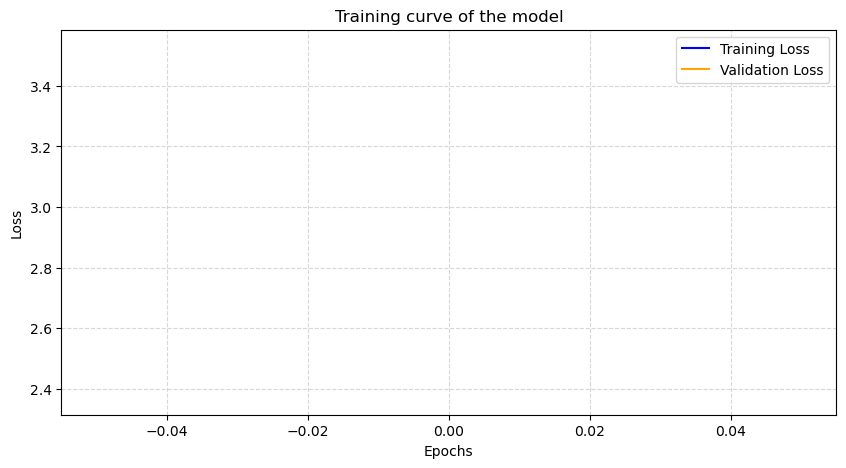

Plot saved to: ./plots/training_curve_log.png


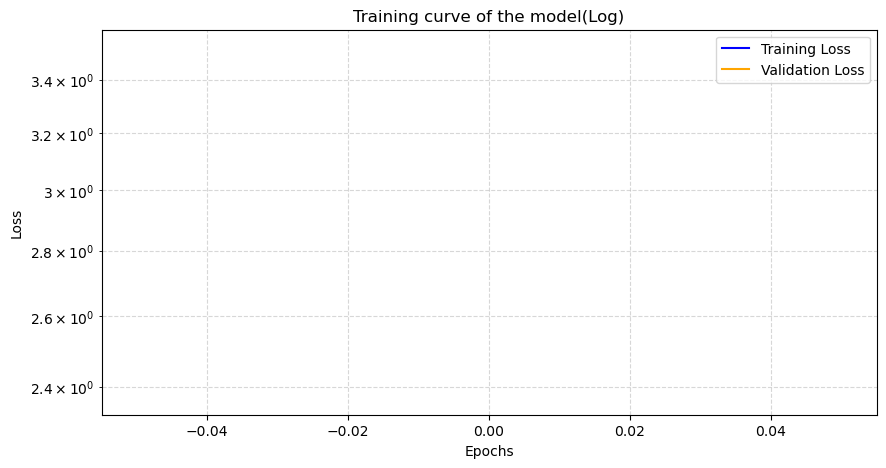

Plot saved to: ./plots/training_curve_0.png


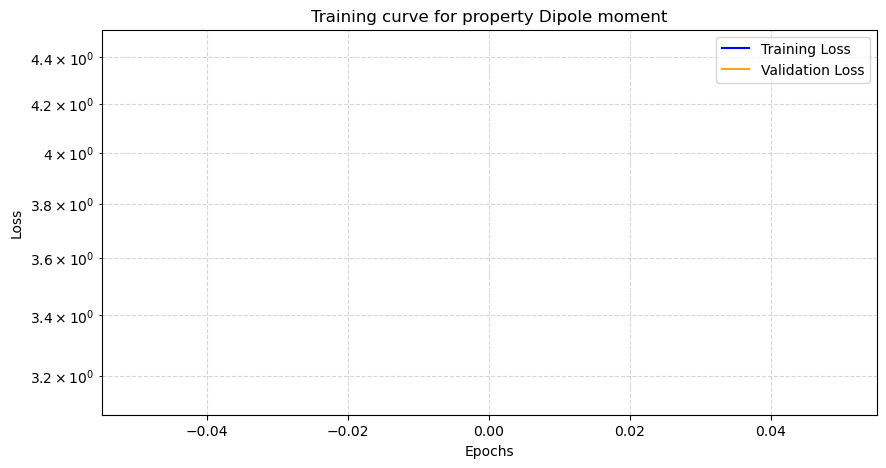

Plot saved to: ./plots/training_curve_1.png


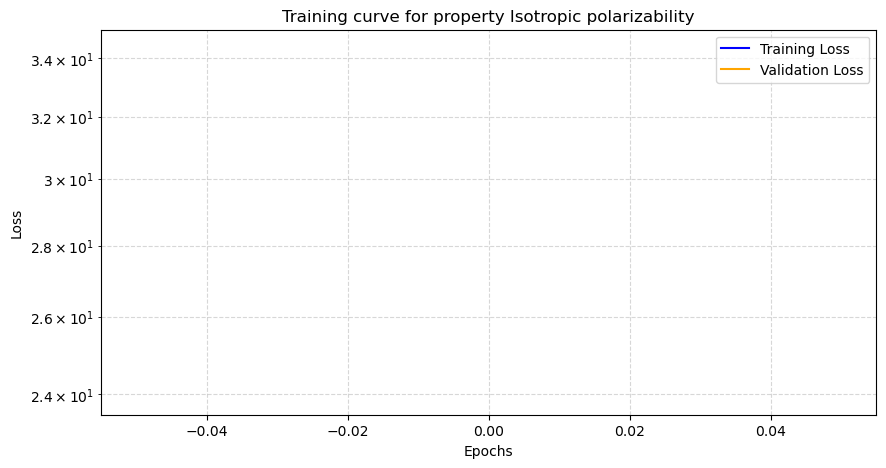

Plot saved to: ./plots/training_curve_2.png


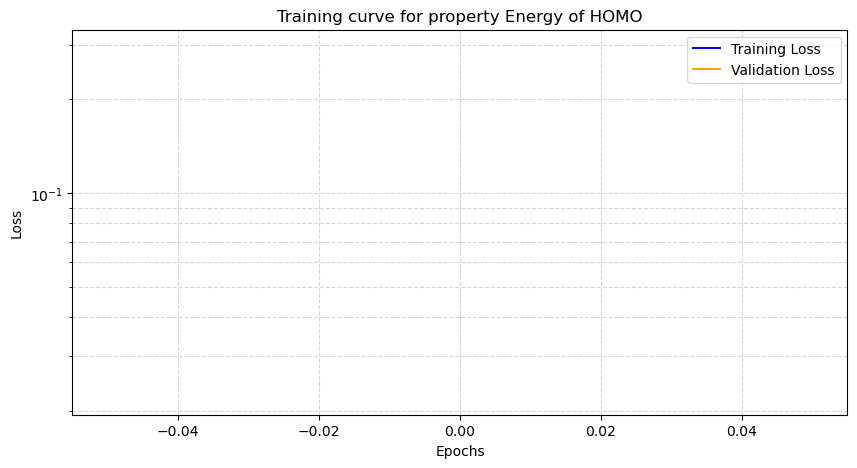

Plot saved to: ./plots/training_curve_3.png


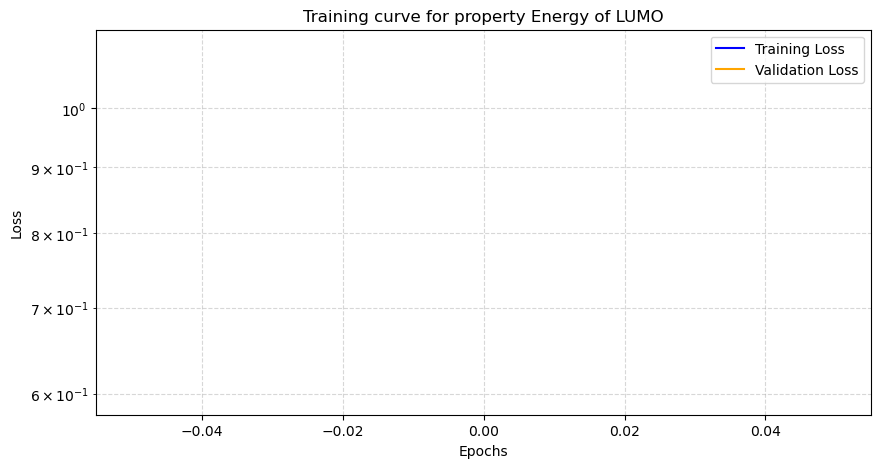

Plot saved to: ./plots/training_curve_4.png


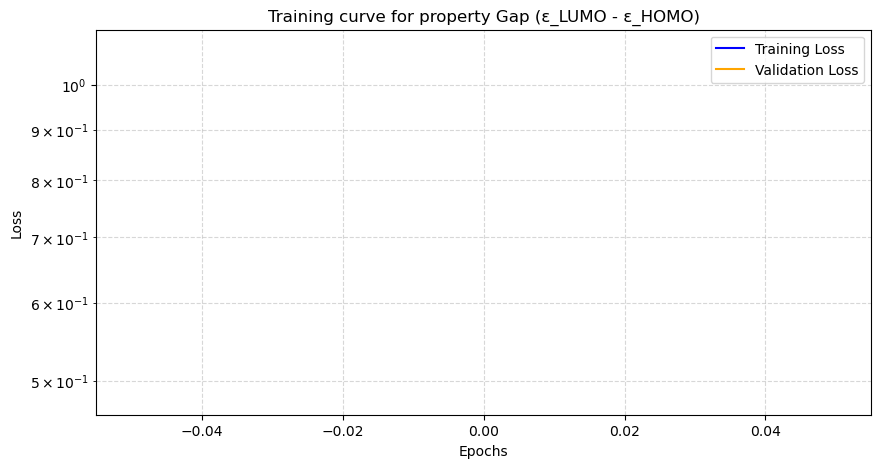

Plot saved to: ./plots/training_curve_5.png


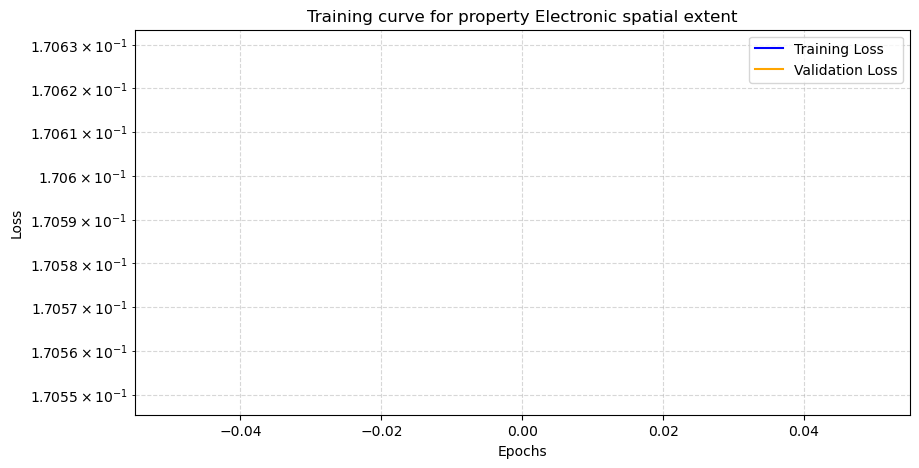

Plot saved to: ./plots/training_curve_6.png


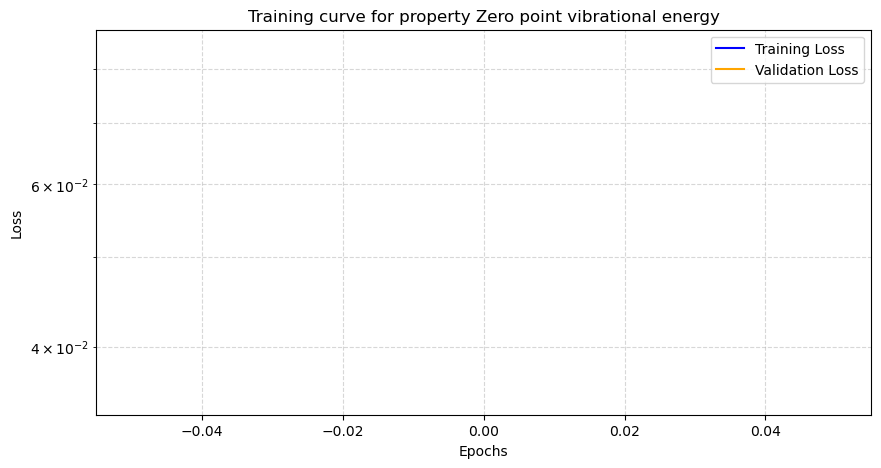

Plot saved to: ./plots/training_curve_7.png


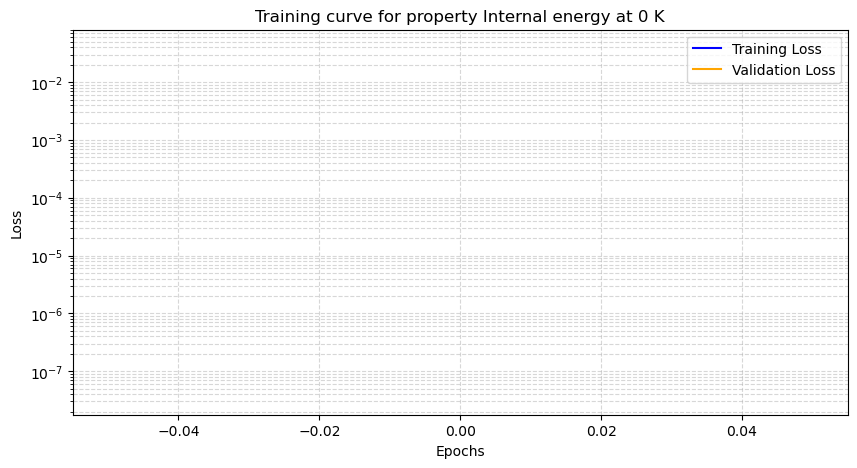

Plot saved to: ./plots/training_curve_8.png


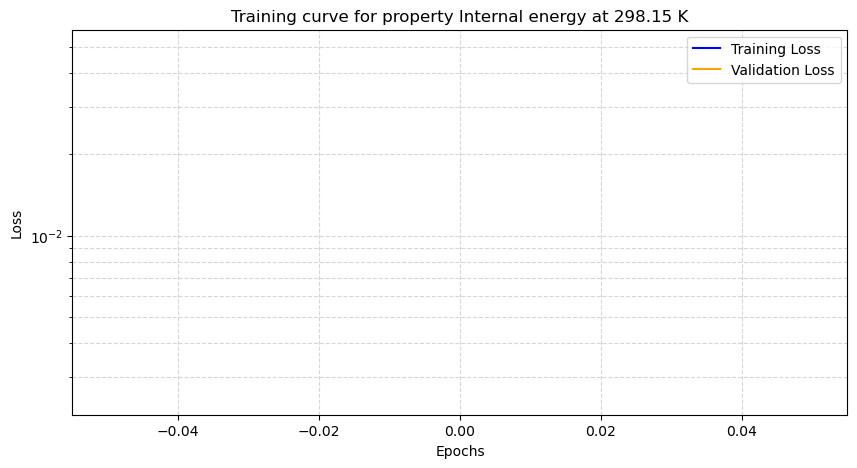

Plot saved to: ./plots/training_curve_9.png


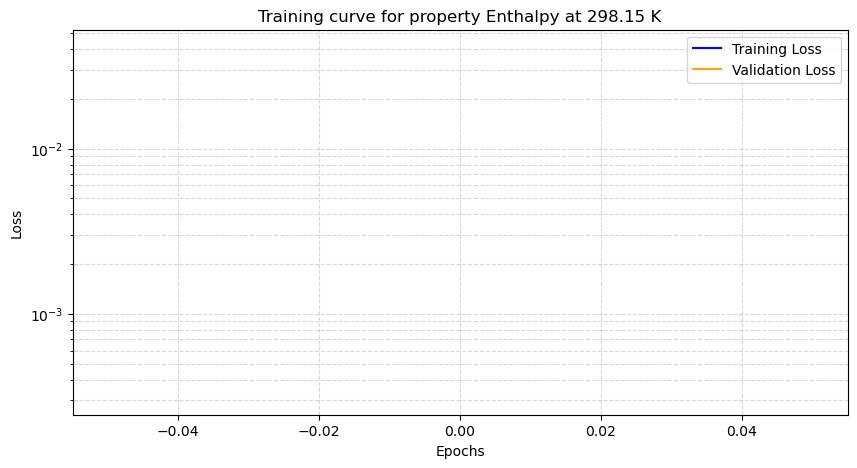

Plot saved to: ./plots/training_curve_10.png


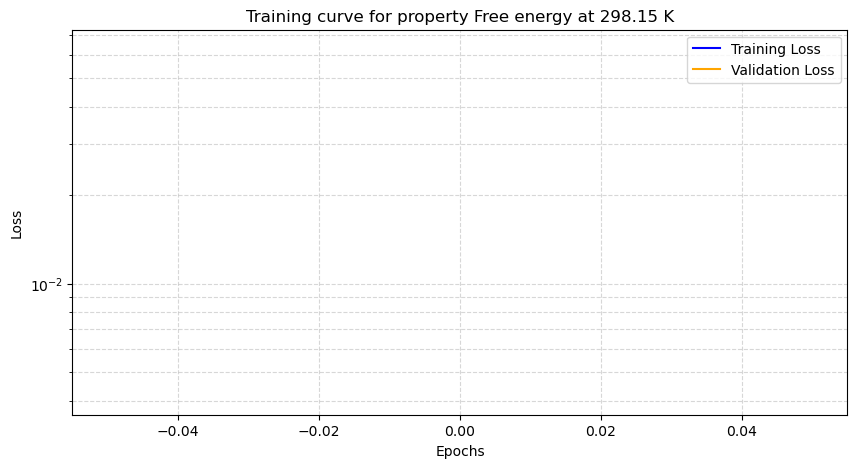

Plot saved to: ./plots/training_curve_11.png


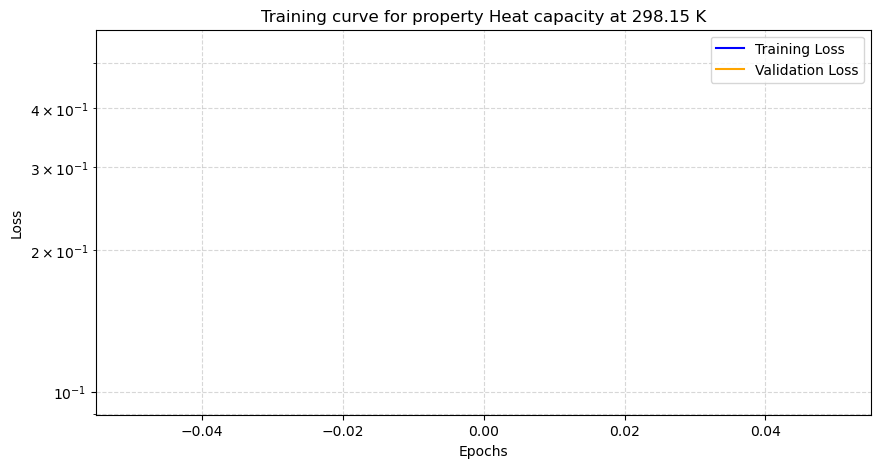

In [ ]:
# Training curves plot
title = f"Training curve of the model"
save_path = f"./plots/training_curve.png"
plot_training_curves(weighted_losses.cpu(), weighted_val_losses.cpu(), log_scale=False, 
                         title=title, save_path=save_path)
title = f"Training curve of the model(Log)"
save_path = f"./plots/training_curve_log.png"
plot_training_curves(weighted_losses.cpu(), weighted_val_losses.cpu(), log_scale=True, 
                         title=title, save_path=save_path)
for i,prop in enumerate(target):
    title = f"Training curve for property {properties_dict[prop]['Description']}"
    save_path = f"./plots/training_curve_{i}.png"
    plot_training_curves(train_loss[:,i].cpu(), valid_loss[:,i].cpu(), log_scale=True, 
                         title=title, save_path=save_path)

Evaluation
Property: Dipole moment, Test Loss: 0.761728, Test MAE:0.872771 D
Plot saved to: ./plots/predictions_0.png


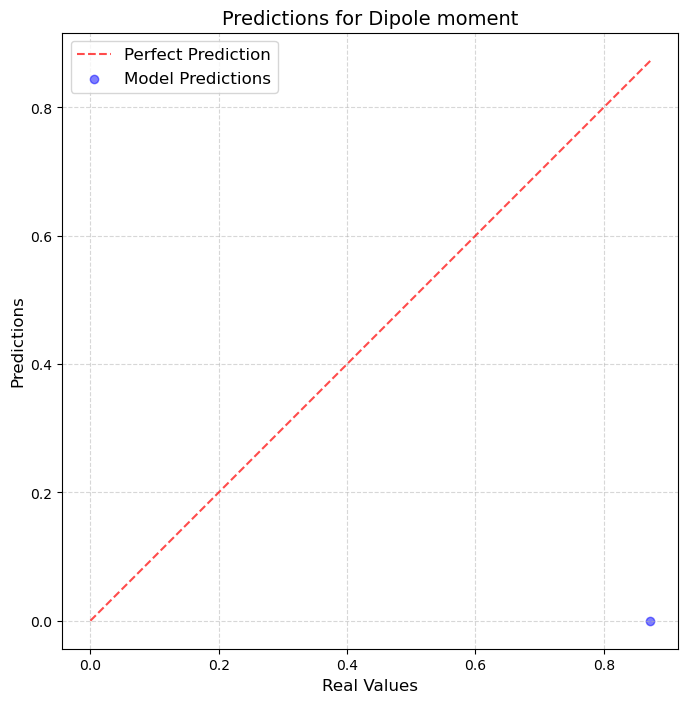

Property: Isotropic polarizability, Test Loss: 1264.205811, Test MAE:35.555672 a₀³
Plot saved to: ./plots/predictions_1.png


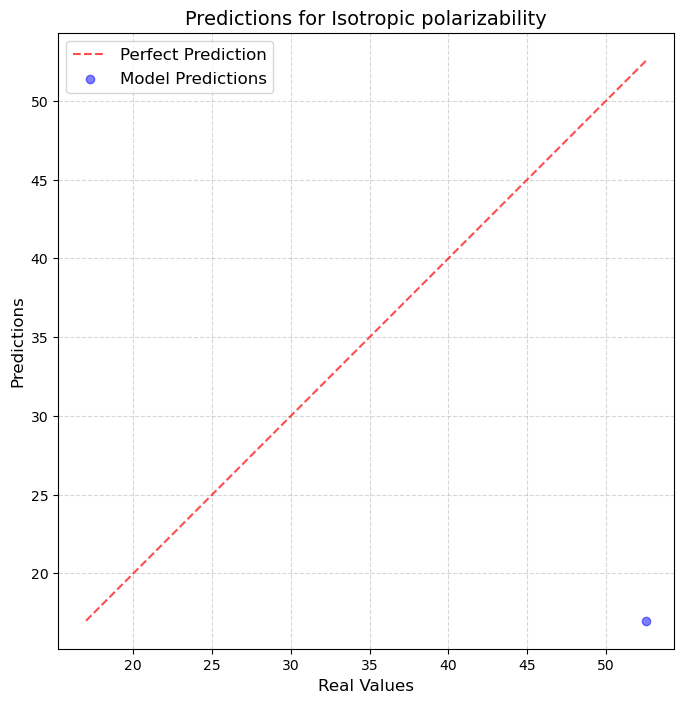

Property: Energy of HOMO, Test Loss: 0.943404, Test MAE:0.971290 eV
Plot saved to: ./plots/predictions_2.png


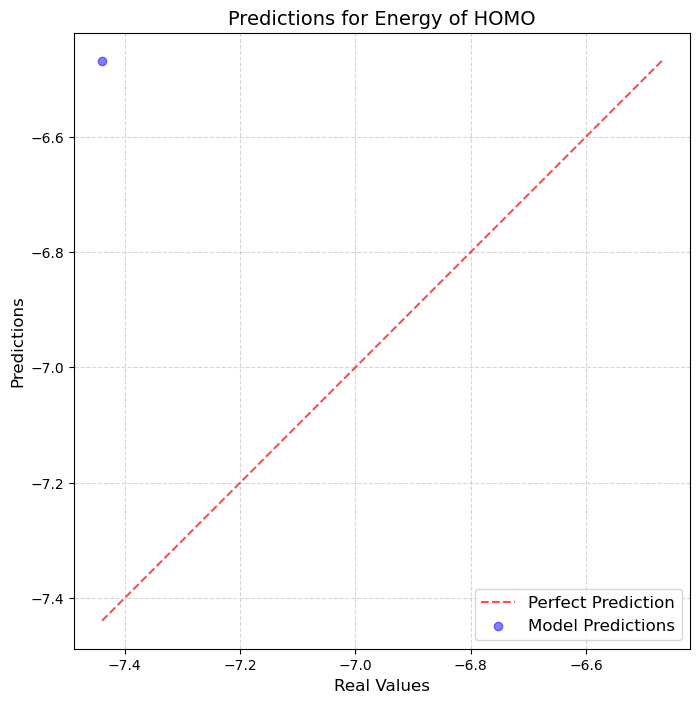

Property: Energy of LUMO, Test Loss: 7.279333, Test MAE:2.698024 eV
Plot saved to: ./plots/predictions_3.png


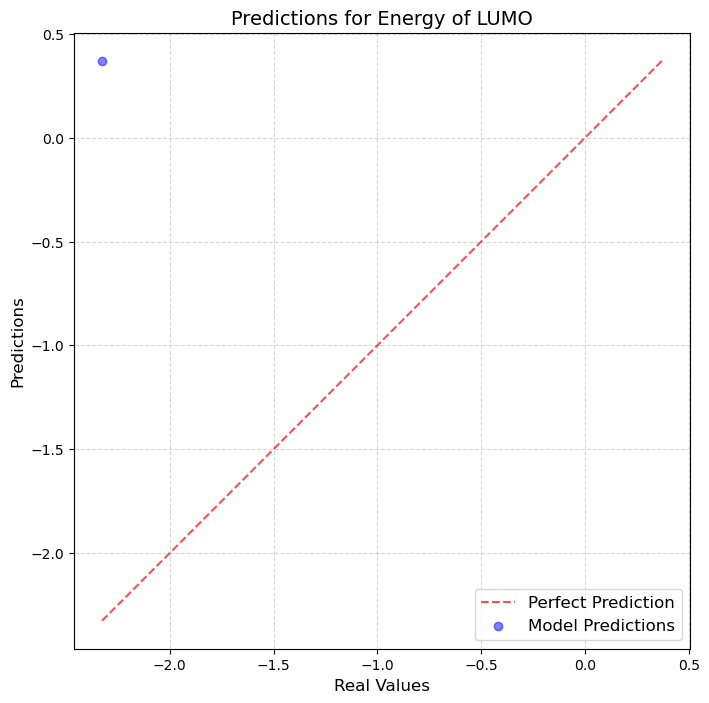

Property: Gap (ε_LUMO - ε_HOMO), Test Loss: 2.972222, Test MAE:1.724013 eV
Plot saved to: ./plots/predictions_4.png


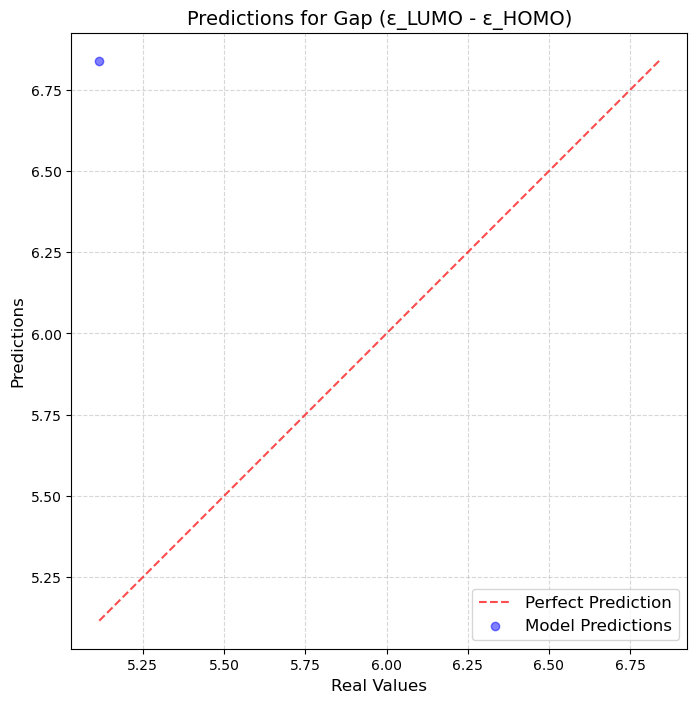

Property: Electronic spatial extent, Test Loss: 10051.016602, Test MAE:100.254761 a₀²
Plot saved to: ./plots/predictions_5.png


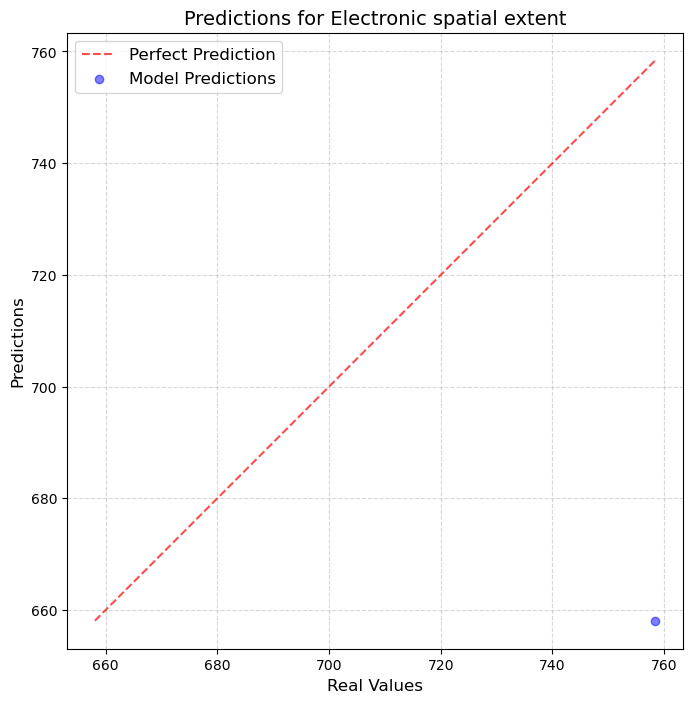

Property: Zero point vibrational energy, Test Loss: 0.315331, Test MAE:0.561543 eV
Plot saved to: ./plots/predictions_6.png


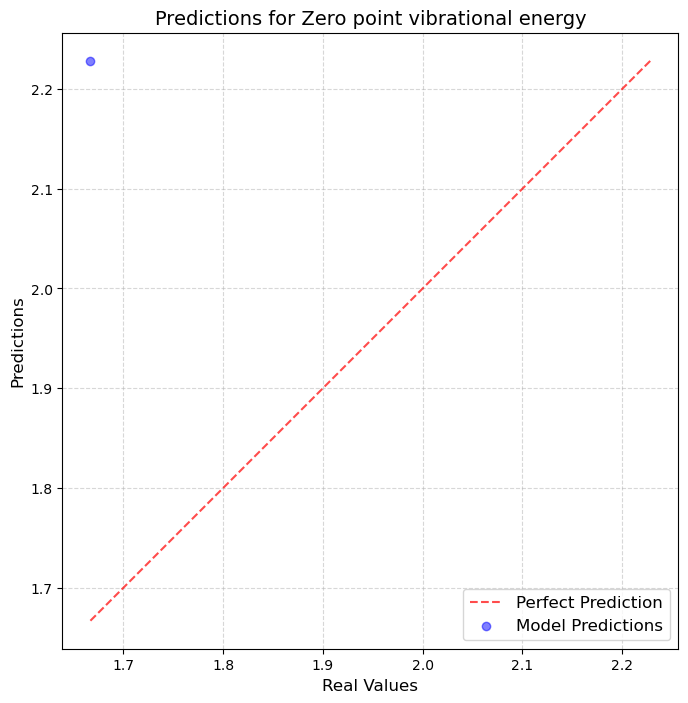

Property: Internal energy at 0 K, Test Loss: 8.243179, Test MAE:2.871094 eV
Plot saved to: ./plots/predictions_7.png


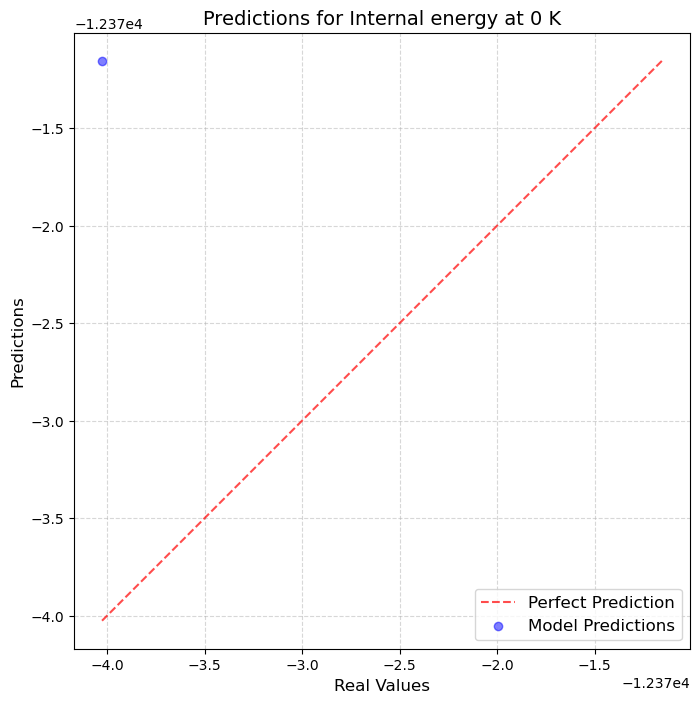

Property: Internal energy at 298.15 K, Test Loss: 6.476627, Test MAE:2.544922 eV
Plot saved to: ./plots/predictions_8.png


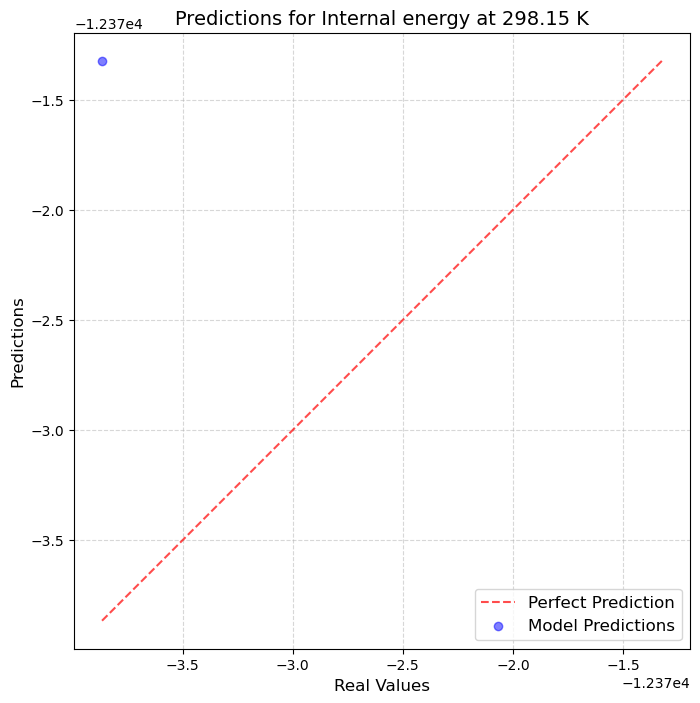

Property: Enthalpy at 298.15 K, Test Loss: 7.476807, Test MAE:2.734375 eV
Plot saved to: ./plots/predictions_9.png


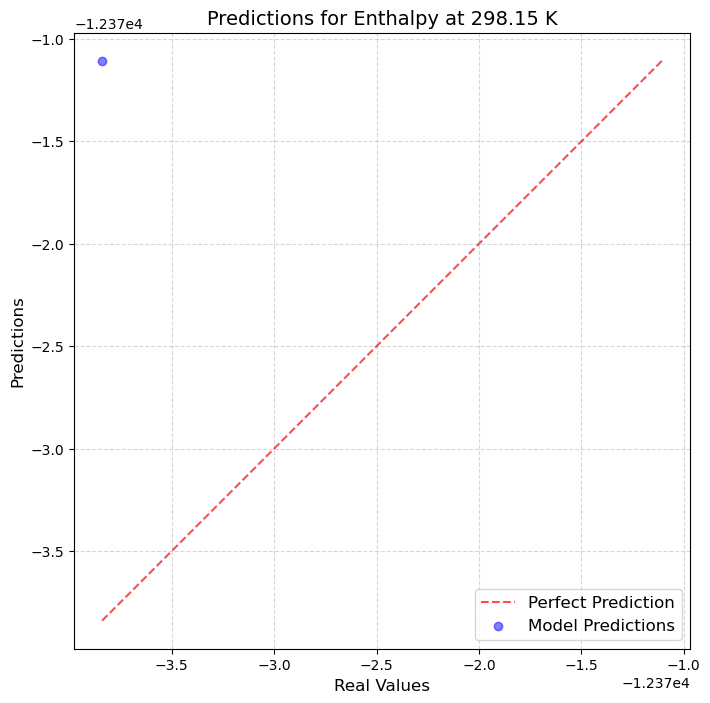

Property: Free energy at 298.15 K, Test Loss: 6.118859, Test MAE:2.473633 eV
Plot saved to: ./plots/predictions_10.png


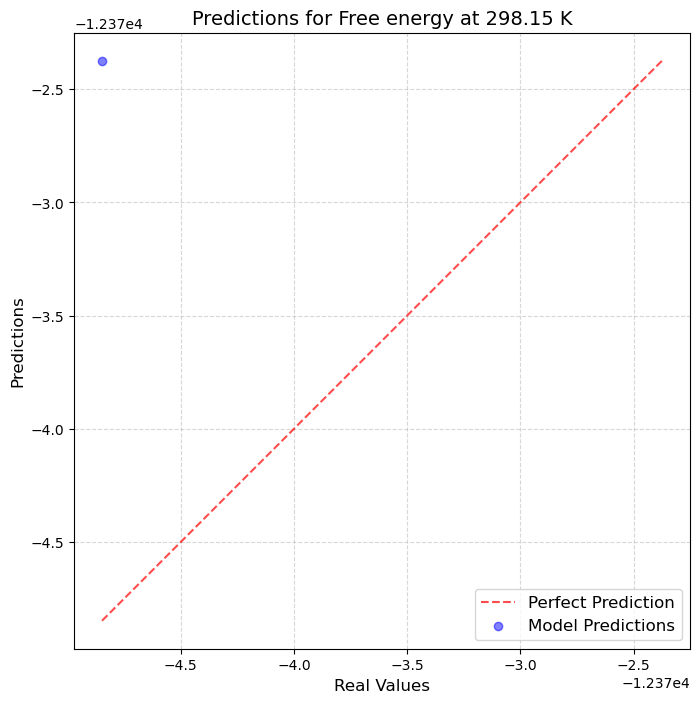

Property: Heat capacity at 298.15 K, Test Loss: 12.139474, Test MAE:3.484175 cal/molK
Plot saved to: ./plots/predictions_11.png


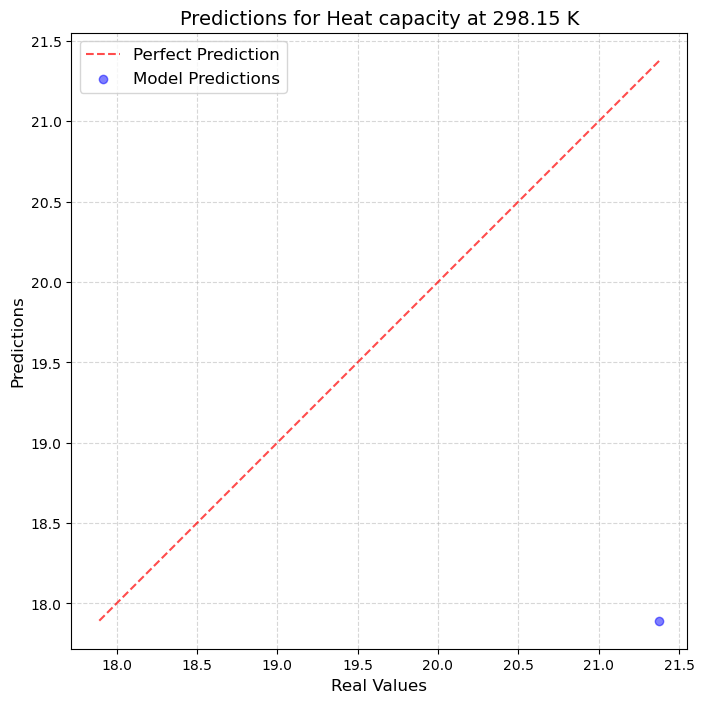

In [ ]:
# Evaluation
device = 'cuda' if torch.cuda.is_available() else "cpu"
test_loss, test_mae, real_values, predictions = evaluate(model, test_loader, criterion, device, return_predictions=True)
print("Evaluation")
for i, (t_loss, t_mae) in enumerate(zip(test_loss, test_mae)):
    prop = target[i]
    print(f"Property: {properties_dict[prop]['Description']}, "
                    f"Test Loss: {t_loss:.6f}, Test MAE:{t_mae:.6f} {properties_dict[prop]['Unit']}")
     # XY plot
    title = f"Predictions for {properties_dict[prop]['Description']}"
    save_path = f"./plots/predictions_{i}.png"
    plot_predictions_vs_real(real_values=real_values[:,i].cpu(),predictions=predictions[:,i].cpu(), 
                             title=title, save_path=save_path)

In [ ]:
# Save losses and model
loss_dict = {
    'train_loss': train_loss,
    'valid_loss': valid_loss,
    'test_loss':test_loss,
    'test_mae':test_mae
}  